<a href="https://colab.research.google.com/github/anh1811/YOLO/blob/main/yolov1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
from IPython.display import Image, clear_output  # to display images
import torchvision
import pickle as pkl
import numpy as np
import os
import cv2
from torchvision import transforms
clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Setup complete. Using torch 1.9.0+cu102 (Tesla T4)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Dataset/Dataloader**

In [3]:
# #Load the VOC dataset
# # !wget https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
# # !wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
# # !wget https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
# #let's just load it in content
!cd /content/
!tar xf /content/drive/MyDrive/Data/yolov1/data/VOCtrainval_11-May-2012.tar
!tar xf /content/drive/MyDrive/Data/yolov1/data/VOCtrainval_06-Nov-2007.tar
!tar xf /content/drive/MyDrive/Data/yolov1/data/VOCtest_06-Nov-2007.tar

In [4]:
#transform the dataset
# this code is stolen from YOLO:Darknet pjreddie.com
!wget https://pjreddie.com/media/files/voc_label.py
!python voc_label.py

--2021-08-13 07:22:18--  https://pjreddie.com/media/files/voc_label.py
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2042 (2.0K) [application/octet-stream]
Saving to: ‘voc_label.py’

voc_label.py        100%[===================>]   1.99K  --.-KB/s    in 0s      

2021-08-13 07:22:18 (458 MB/s) - ‘voc_label.py’ saved [2042/2042]



In [5]:
#create data loader, dataset
class DataSet(torch.utils.data.Dataset):
  def __init__(self, path_img, path_txt, transform):
    self.list_img = []
    with open(path_img, 'r') as file:
      self.list_img = [line.strip() for line in file]
    self.transform = transform
    self.path_img = path_img
    self.path_txt = path_txt
  
  def __getitem__(self, i):
    # test if the index is an int for slice:
      #TODO 
    
    img_path = self.list_img[i]
    box_path = self.list_img[i].split('/')[-1][:-4] + '.txt'
    
    img = cv2.imread(img_path)
    with open(os.path.join(self.path_txt, box_path), 'r') as file:
      boxes = []
      for line in file.readlines():
        box = [float(a) for a in line.split(' ')]
        boxes.append(box)
    boxes = np.array(boxes)

    sample = [img, boxes]
    if self.transform:
      sample = self.transform(sample)

    return sample[0].float(), sample[1].float()
  
  def __len__(self):
    return len(self.list_img)

In [6]:
class Padding(object):
    def __init__(self, inp_dim):
        assert isinstance(inp_dim, (int, tuple))
        self.inp_dim = inp_dim
        
    def __call__(self, sample):
        img, boxes = sample[0], sample[1]
        w, h = img.shape[1], img.shape[0]
        scale = min(self.inp_dim/w, self.inp_dim/h)
        
        # one of this axis will have the same length as the inp_dim
        w_new = int(w * scale)
        h_new = int(h * scale)
        img = cv2.resize(img, (w_new, h_new))
        
        #bring the box to the original dimensional
        boxes[:,[1,3]] *= w
        boxes[:,[2,4]] *= h
        #rescale the box
        boxes[:, 1:] *= scale
        boxes[:, 1] += (self.inp_dim - w_new)//2
        boxes[:, 2] += (self.inp_dim - h_new)//2

        #rescale back the image
        boxes[:, [1,3]] /= self.inp_dim
        boxes[:, [2,4]] /= self.inp_dim
        
        #create a image that is full 128
        image = np.full((self.inp_dim, self.inp_dim, 3), 128.)
        #paste the img into the middle
        image[(self.inp_dim - h_new)//2:(self.inp_dim - h_new)//2 + h_new, 
              (self.inp_dim - w_new)//2:(self.inp_dim - w_new)//2 + w_new,  :] = img
        return image, boxes

class ToTensor(object):
    def __call__(self, sample):
        image, rec = sample[0], sample[1]
        to_tensor = transforms.ToTensor()
        return to_tensor(image), to_tensor(rec)

class Normalize(object):
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std
  
  def __call__(self, sample):
   normalize = transforms.Normalize(mean = self.mean, std = self.std)
   return normalize(sample[0]), sample[1]
        

In [7]:
basic_transform = transforms.Compose([Padding(inp_dim = 448), 
                                      ToTensor(),
                                      Normalize(mean = 0, std = 255.)])
path_img = '/content/2007_train.txt'
path_label = '/content/VOCdevkit/VOC2007/labels'
dataset = DataSet(path_img=path_img, path_txt= path_label, transform=basic_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


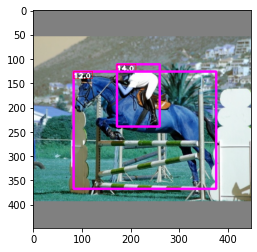

In [8]:
img = dataset[1][0].cpu().numpy()
img = np.ascontiguousarray(np.transpose(img, (1,2,0))) 
img_attri = dataset[1][1].squeeze(0)
for i in range(img_attri.size(0)):
  attri = img_attri[i]
  label = "{0}".format(attri[0])
  box = attri[1:]
  box *= 448
  box = torchvision.ops.box_convert(box, 'cxcywh', 'xyxy')
  box = box.numpy()
  xmin ,ymin, xmax, ymax = box
  #bug issues: rectangle return Umat type if np.array is not contiguous 
  img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255,0,255), 3)
  t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
  img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmin)+ t_size[0] + 3, int(ymin) +t_size[1] + 4)
                                ,(255,0,0), 1)
  img = cv2.putText(img, label, (int(xmin), int(ymin) + t_size[1] + 4), 
                              cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 2)
plt.imshow(img)

In [9]:
def my_collate(batch):
    tensor_image = batch[0][0]
    for image,_ in batch[1:]:
      tensor_image = torch.cat((tensor_image,image), 0)
    rectangle = [item[1] for item in batch]
    tensor_image = tensor_image.view(-1,3,448,448).contiguous()
    return [tensor_image, rectangle]

train_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           collate_fn=my_collate,
                                            batch_size=64, 
                                           shuffle=True,
                                          pin_memory=True)

In [10]:
data_iter = iter(train_loader)
frame = next(data_iter)

# **Model**

In [11]:
# creat model
folder_dir = '/content/drive/MyDrive/Data/yolov1' 
os.makedirs('/content/drive/MyDrive/Data/yolov1', exist_ok=True)
# %cd /content/drive/MyDrive/Data/yolov1/
# # %mkdir cfg
%cd /content/drive/MyDrive/Data/yolov1/cfg/
# !wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov1-tiny.cfg

/content/drive/MyDrive/Data/yolov1/cfg


In [12]:
def parsefile(file):
    #read config file and return a list of dictionary 
    config = open(file, 'r')
    lines = config.read().split('\n')
    lines = [x for x in lines if len(x) != 0]
    lines = [x for x in lines if x[0] != '#']
    lines = [x.strip() for x in lines] 
    
    block = {}
    blocks = []

    for line in lines:
        if line[0] == '[':
            if len(block) != 0:
                blocks.append(block)
                block = {}
            block['type'] = line[1:-1].rstrip()
        else:
            key, value = line.split('=')
            block[key.rstrip()] = value.lstrip()
    blocks.append(block)
    return blocks      

First i want to create FastYolo model

In [13]:
def building_fast_yolo(blocks):
    # building model from block 
    # parameters = blocks 
    
    #model info
    net_info = blocks[0]
    list_module = nn.ModuleList()
    input_size = 3
    output_filters = []
    for i, block in enumerate(blocks[1:]):
        module = nn.Sequential() #convol module can have a lot of layer
        
        #convolutional layer
        if block['type'] == 'convolutional':
            # is there batch_normalize 
            try:
                batch_normalize = int(block['batch_normalize'])
                bias = False
            except:
                batch_normalize = 0
                bias = True
            
            # arguments for conv2d
            output_size = int(block['filters'])
            kernel_size = int(block['size'])
            stride = int(block['stride'])
            pad = int(block['pad'])

            if pad:
                padding = (kernel_size - 1) // 2
            else:
                padding = 0
            conv = nn.Conv2d(input_size, output_size, kernel_size = kernel_size, stride = stride, padding = padding,
                            bias = bias)
            module.add_module('conv_{}'.format(i), conv)
            
            #perform batch_normalize
            if batch_normalize:
                batchnorm = nn.BatchNorm2d(output_size)
                module.add_module('batchnorm_{}'.format(i), batchnorm)
            
            #perform activation function
            activation_func = block['activation']
            if activation_func == 'leaky':
                leaky = nn.LeakyReLU(0.1, inplace = True)
                module.add_module('leaky_{}'.format(i), leaky)
        
        #maxpool
        elif block['type'] == 'maxpool':
            stride = int(block['stride'])
            size = int(block['size'])
            maxpool = nn.MaxPool2d(size, stride=stride)
            module.add_module('maxpool_{}'.format(i), maxpool)
        
        
        # #dropout
        # elif block['type'] == 'dropout':
        #     prob = float(block['probability'])
        #     dropout = nn.Dropout2d(prob)
        #     module.add_module('dropout_{}'.format(i), dropout)
        
        #connected
        elif block['type'] == 'connected':
          output_size = int(block['output'])
          flatten = nn.Flatten()
          module.add_module('flatten_{}'.format(i), flatten)
          input_size *= 49
          activation_func = block['activation']
          fc = nn.Linear(input_size, output_size)
          module.add_module('fc_{}'.format(i), fc)
        
        elif block['type'] == 'detection':
            detection =  EmptyLayer()
            module.add_module("Detection_{}".format(i), detection)
        
        output_filters.append(output_size)
        list_module.append(module)
        input_size = output_size
    return (net_info, list_module)


class EmptyLayer(nn.Module):
    def __init__(self):
        super(EmptyLayer, self).__init__()

In [14]:
file = parsefile('yolov1-tiny.cfg.1')
building_fast_yolo(file)[1]

ModuleList(
  (0): Sequential(
    (conv_0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm_0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (1): Sequential(
    (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (3): Sequential(
    (maxpool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Sequential(
    (conv_4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm_4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [15]:
class Darknetbase(nn.Module):
  def __init__(self, file, use_fc = False):
    super(Darknetbase, self).__init__()
    self.blocks = parsefile(file)
    self.features = building_fast_yolo(self.blocks)[1][:-2]
    self.use_fc = use_fc
    if use_fc:
      self.fc = self.features.append(
          nn.Sequential(
              nn.AvgPool2d(7),
              nn.Conv2d(1024, 1000, 1, 1, padding = 0),
              nn.Softmax2d()
          )
      )  

  def forward(self, x):
    for module in self.features:
      x = module(x)
    if self.use_fc:
      x = self.fc(x)
  
  def _initialize_weights(self):
        for m in self.features:
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
  
  # def load_weight(self, weightfile):
  #       with open (weightfile, 'rb') as file:
  #           # #read the head first which include 5 32-int values
  #           # # information about the head file @@
  #           # header = np.fromfile(file, dtype = np.int32, count = 4)
  #           # self.header = torch.from_numpy(header)
  #           # self.seen = self.header[2] #number of images seen by the network during training
            
  #           #the rest is the weight of the model
  #           weights = np.fromfile(file, dtype = np.float32)
  #           print(weights.shape)
  #           modules = self.blocks[1 : -2]
  #           pr = 0
  #           for i,module in enumerate(modules):
  #               module_type = module['type']
  #               if module_type == 'convolutional':
  #                   model = self.features[i]
  #                   #check if there is a batchnorm
  #                   try:
  #                       batch_norm = int(module['batch_normalize'])
  #                   except:
  #                       batch_norm = 0
                    
  #                   conv_layer = model[0]
  #                   # weight for batch_normalisation include : bias, weight, running means and running vals
  #                   if batch_norm:
  #                       batch_layer = model[1]
  #                       layer_size = batch_layer.bias.numel()
                        
  #                       #bias 
  #                       bias = torch.from_numpy(weights[pr:pr + layer_size]).view_as(batch_layer.bias)
  #                       batch_layer.bias.data.copy_(bias)
  #                       pr += layer_size
                        
  #                       #weight
  #                       weight = torch.from_numpy(weights[pr:pr + layer_size]).view_as(batch_layer.weight)
  #                       batch_layer.weight.data.copy_(weight)
  #                       pr += layer_size
                        
  #                       #running_mean
  #                       mean = torch.from_numpy(weights[pr:pr + layer_size]).view_as(batch_layer.running_mean)
  #                       batch_layer.running_mean.copy_(mean)
  #                       pr += layer_size
                        
  #                       #running_val
  #                       var = torch.from_numpy(weights[pr:pr + layer_size]).view_as(batch_layer.running_var)
  #                       batch_layer.running_var.data.copy_(var)
  #                       pr += layer_size
  #                   else:
  #                       #load the bias for conv
  #                       layer_size = conv_layer.bias.numel()
  #                       bias = torch.from_numpy(weights[pr:pr + layer_size]).view_as(conv_layer.bias)
  #                       conv_layer.bias.data.copy_(bias)
  #                       pr += layer_size
                    
  #                   # load weight file for conv
  #                   num_weight = conv_layer.weight.numel()
  #                   weight = torch.from_numpy(weights[pr:pr + num_weight]).view_as(conv_layer.weight)
  #                   conv_layer.weight.data.copy_(weight)
  #                   pr += num_weight


  #           model = self.features[-1]
  #           num_bias = model.bias.numel()
  #           bias = torch.from_numpy(weights[pr: pr + num_bias]).view_as(model.bias)
  #           model.bias.data.copy_(bias)
  #           pr += num_bias

  #           num_weight = model.weight.numel()
  #           weight = torch.from_numpy(weights[pr: pr + num_weight]).view_as(model.weight)
  #           model.weight.data.copy_(weight)
  #           pr += num_weight
  #           print(weights[pr:])
            
              
              

In [16]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [17]:
# !wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/darknet.cfg
# !wget http://pjreddie.com/media/files/darknet.conv.weights
Darknet = Darknetbase('yolov1-tiny.cfg.1', use_fc = False)
count_parameters(Darknet)
# Darknet.features
# Darknet.load_weight('darknet.weights')
  

+---------------------------------+------------+
|             Modules             | Parameters |
+---------------------------------+------------+
|     features.0.conv_0.weight    |    432     |
|  features.0.batchnorm_0.weight  |     16     |
|   features.0.batchnorm_0.bias   |     16     |
|     features.2.conv_2.weight    |    4608    |
|  features.2.batchnorm_2.weight  |     32     |
|   features.2.batchnorm_2.bias   |     32     |
|     features.4.conv_4.weight    |   18432    |
|  features.4.batchnorm_4.weight  |     64     |
|   features.4.batchnorm_4.bias   |     64     |
|     features.6.conv_6.weight    |   73728    |
|  features.6.batchnorm_6.weight  |    128     |
|   features.6.batchnorm_6.bias   |    128     |
|     features.8.conv_8.weight    |   294912   |
|  features.8.batchnorm_8.weight  |    256     |
|   features.8.batchnorm_8.bias   |    256     |
|    features.10.conv_10.weight   |  1179648   |
| features.10.batchnorm_10.weight |    512     |
|  features.10.batch

8654224

In [18]:
# for name, param in Darknet.named_parameters():
#     if param.requires_grad and name == 'features.0.conv_0.weight':
#         print ('{} {}'.format(name, param.data))

In [19]:
with open('darknet.weights', 'rb') as file:
  weight = np.fromfile(file, dtype = np.float32)
  print(weight.shape)

(7323484,)


In [20]:
class YOLOV1tiny(nn.Module):
  def __init__(self, file, features):
      super(YOLOV1tiny, self).__init__()
      self.blocks = parsefile(file)
      self.net_info, self.module_list = building_fast_yolo(self.blocks)
      self.inp_dims = int(self.net_info['height'])
      detection_layer = self.blocks[-1]
      self.grid_size = int(detection_layer['side'])
      self.num_classes = int(detection_layer['classes'])
      self.num_box = int(detection_layer['num'])
      if features:
        for i, module in enumerate(features):
          self.module_list[i] = module
      self.float().to(device)
  
  def forward(self, x, CUDA):
    
    x = x.to(device)
    for i, module in enumerate(self.blocks[1:]):
      module_type = module['type']
      if module_type == 'detection':
        batch_size = x.size(0)
        detection = x.view(batch_size, self.num_box * 5 + self.num_classes, self.grid_size, self.grid_size)
      else:
         x = self.module_list[i](x)
    return detection

In [21]:
model = YOLOV1tiny('yolov1-tiny.cfg.1', Darknet.features)
count_parameters(model)

+------------------------------------+------------+
|              Modules               | Parameters |
+------------------------------------+------------+
|    module_list.0.conv_0.weight     |    432     |
|  module_list.0.batchnorm_0.weight  |     16     |
|   module_list.0.batchnorm_0.bias   |     16     |
|    module_list.2.conv_2.weight     |    4608    |
|  module_list.2.batchnorm_2.weight  |     32     |
|   module_list.2.batchnorm_2.bias   |     32     |
|    module_list.4.conv_4.weight     |   18432    |
|  module_list.4.batchnorm_4.weight  |     64     |
|   module_list.4.batchnorm_4.bias   |     64     |
|    module_list.6.conv_6.weight     |   73728    |
|  module_list.6.batchnorm_6.weight  |    128     |
|   module_list.6.batchnorm_6.bias   |    128     |
|    module_list.8.conv_8.weight     |   294912   |
|  module_list.8.batchnorm_8.weight  |    256     |
|   module_list.8.batchnorm_8.bias   |    256     |
|   module_list.10.conv_10.weight    |  1179648   |
| module_lis

27095374

In [22]:
# !wget https://pjreddie.com/media/files/yolov1/tiny-yolov1.weights
# model.load_weight('tiny-yolov1.weights') #wrong

# **Loss**

In [23]:
def loss_functionv1(pre, target, inp_dims, grid_size, num_classes, num_box):
  #loss_functionv1 use only the prediction in each grid cell of the image, 
  # for each grid cell there can only one object with one class
  
  # pre(Batch x (num_box*5+num_classes)x grid x grid))
  batch_size = pre.size()[0] #
  #transform into (batchx(grid^2x)x(nm_classes + 5 *numbox)
  pre = pre.view(batch_size, -1, grid_size*grid_size)
  pre = pre.transpose(2,1).contiguous()

  #define loss
  loss_class = nn.CrossEntropyLoss(reduction = 'sum')
  loss_box = nn.MSELoss(reduction = 'sum')
  loss_obj = nn.MSELoss(reduction = 'sum')

  #target list each element is a list of tensor 1 x num_obj x [1(class) + obj_attribute]]
  lclas = 0
  lobj = 0
  lbox = 0
  for i in range(batch_size): 
    # for each image
    # create a array with size of number_grid to indicate whether the grid have obj 
    is_obj = torch.zeros((grid_size*grid_size)).to(device)
    
    # this label for the img
    img = target[i].squeeze(0).to(device) #num_objx5
    num_obj = img.size(0) 
    
    # index will be the obj's index + 1 if it has obj else 0 
    for j in range(num_obj):
      obj = img[j] #5
      is_obj[int(obj[1]*grid_size) + grid_size * int(obj[2]*grid_size)] = j+1 
    
    predict = pre[i] #(grid*gridx30)    
    os_tar = []
    os_pre = []
    for grid in range(grid_size*grid_size):
      index = int(is_obj[grid])
      cell = predict[grid] #(30)
      boxes = cell[:(5*num_box)].view(-1,5) #(2,5)
      class_pre = cell[(5*num_box):].unsqueeze(0) #(1,20)
      #if there is a obj in grid
      if index:
        obj = img[index - 1] #5
        class_tar = obj[0].unsqueeze(0).long() #size(1)
        lclas += loss_class(class_pre, class_tar)
    
        # two box vs their ground truth box
        
        # transform the ground_truth_box
        gt_box = box_for_loss(obj[1:], grid).unsqueeze(0).to(device) #(1,4)
        gt_box = torchvision.ops.box_convert(gt_box, 'cxcywh', 'xyxy')
        pre_box = torchvision.ops.box_convert(boxes[:,0:4], 'cxcywh', 'xyxy') #(2,4)
        box_iou = torchvision.ops.box_iou(pre_box, gt_box)   #(2,1)
        
        # value and indice of the box with the highest iou
        # the iou is the confidence score target
        os, index_obj = torch.max(box_iou, 0) #1,1
        os_tar.extend(os)
        os_pre.extend(boxes[index_obj, 4])

        # loss for the x,y and height, width with the box resposible
        box_obj = boxes[index_obj]
        lbox += loss_box(box_obj[:,0:2], gt_box[:,0:2]) 
        lbox += loss_box(torch.square(box_obj[:,2:4]),torch.square(gt_box[:,2:4]))
        
        # loss for box coordinate for box not responsible
        index_nobj = (torch.arange(num_box).to(device) != index_obj).nonzero(as_tuple=True)[0]
        os_box_nobj = boxes[index_nobj, 4]
        lobj += 0.5 * loss_obj(os_box_nobj, torch.zeros((os_box_nobj.size())).to(device))

      else:
        # grid with no object
        os_box_nobj = boxes[:, 4] #2,4
        lobj += 0.5 * loss_obj(os_box_nobj, torch.zeros((os_box_nobj.size())).to(device))
    lobj += loss_obj(torch.as_tensor(os_pre, dtype = torch.float), torch.as_tensor(os_tar, dtype = torch.float))
  loss = (5 * lbox + lobj + lclas)
  return loss.float()

In [24]:
def box_for_loss(box, grid):
  """
  tranform the box in the groundtruth to the detection
  """
  new_box = box.clone()
  new_width = new_box[0] * 7
  new_height = new_box[1] *7
  new_box[0] = new_width - int(new_width)
  new_box[1] = new_height - int(new_height) 

  return new_box

In [25]:
# for g in optimizer.param_groups:
#   print(g['lr'])

# **Train**

In [49]:
Darknet = Darknetbase('yolov1-tiny.cfg.1', use_fc = False)
Darknet._initialize_weights()
model = YOLOV1tiny('yolov1-tiny.cfg.1', Darknet.features)

In [59]:
import gc

gc.collect()

torch.cuda.empty_cache()
#get grid_size, num_box, num_classes
grid_size = model.grid_size
num_box = model.num_box
num_classes = model.num_classes
inp_dims = model.inp_dims
optimizer = torch.optim.SGD(model.parameters(), lr= 0.001, momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.Adam(model.parameters(), lr =0.001, weight_decay = 0.0005, amsgrad=True)
scheduler_epoch = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[76,105,135], gamma=0.1)
scheduler_batch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=10**(1./8.))

epoches = 135
index = 6
len_dataset = len(dataset)

#load_checkpoint
checkpoint = torch.load('model.weight5')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler_epoch.load_state_dict(checkpoint['scheduler'])
loss_epoch = checkpoint['loss'] * len_dataset
epoch_ini = checkpoint['epoch']

for epoch in range(epoch_ini,epoches):
  loss_epoch = 0
  for i, (image, label) in enumerate(train_loader):
    model.train()
    image = Variable(image)
    pre = model(image,  device)
    loss = loss_functionv1(pre, label, inp_dims, grid_size, num_classes, num_box)
    loss_epoch += loss

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch == 0:
      scheduler_batch.step()

  scheduler_epoch.step()

  #save check point
  if epoch % 10 == 0 and epoch != 0:
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler': scheduler_epoch.state_dict(),
        'loss': loss_epoch/len_dataset,
            }, 'model.weight{}'.format(index))
    index += 1
  
  print('Epoch[{}]: {:.7f}'.format(epoch, loss_epoch/len_dataset))

KeyError: ignored

In [55]:
epoch

51

In [ ]:
# torch.save(model.state_dict, 'model_weight1')
frame[1]

In [ ]:
img = dataset[0][0].unsqueeze(0)
# inp_dim = 448
# w, h = img.shape[1], img.shape[0]
# if h > w:
#   h_new = inp_dim
#   w_new = int(w * inp_dim/h)
#   img = cv2.resize(img, (w_new, h_new))
#   img = cv2.copyMakeBorder(img, 0,0,(448 - w_new)//2, (448 - w_new)//2, cv2.BORDER_CONSTANT, (128,128,128))
# else:
#   w_new = inp_dim
#   h_new = int(h * inp_dim/w)
#   img = cv2.resize(img, (w_new, h_new))
#   img = cv2.copyMakeBorder(img, (448 - h_new)//2, (448 - h_new)//2, 0, 0, cv2.BORDER_CONSTANT, (128,128,128))
# img =  img[:,:,::-1].transpose((2,0,1)) 
# img = img[np.newaxis,:,:,:]/255.0       
# img = torch.from_numpy(img).float() 
img = frame[0]
import gc

gc.collect()

torch.cuda.empty_cache()
pre = model(img, device)
print(pre.size())
target = frame[1]
loss_functionv1(pre, target, 448, 7, 20, 2)


# **Detection**

In [52]:
def write_result(pre):
  #transform the detection
  num_classes = 20
  grid_size = 7
  num_grid = grid_size * grid_size
  num_box = 2
  batch_size = pre.size(0)

  pre = pre.view(batch_size, -1, num_grid)
  pre = pre.transpose(2,1).contiguous() # bx49x30
  # score1 = pre[:,:,4].unsqueeze(2).repeat(1,1,num_classes)
  # score2 = pre[:,:,9].unsqueeze(2).repeat(1,1,num_classes)
  score1 = 1
  score2 = 1
  box1 = torch.cat((pre[:,:,:5], pre[:,:,10:] * score1), 2)
  box2 = torch.cat((pre[:,:,5:10], pre[:,:,10:] * score2), 2)
  prediction = torch.cat((box1, box2), 2).view(-1, num_grid * num_box, 5 + num_classes)
  # print(prediction.size())
  # print(prediction[:,0])
  is_output_created = False

  for i in range(batch_size):
    image_tensor = prediction[i,:,:] #batch x 98 x 10
    max_class = torch.max(image_tensor[:, 5:], 1) #(value, index)
    seq = image_tensor[:, :5], max_class[0].float().unsqueeze(1),  max_class[1].float().unsqueeze(1)
    image_tensor = torch.cat(seq,1) #size(98,7)
    zero = torch.zeros(image_tensor[:, 0].size()).to(device)
    image_tensor[:,4] = torch.where(image_tensor[:,4] > .1, image_tensor[:,0], zero)
    index_not_zero = torch.nonzero(image_tensor[:, 4])
    image_tensor_pre = image_tensor[index_not_zero.squeeze(),:].view(-1,7)

    image_tensor_pre_index = torchvision.ops.batched_nms(image_tensor_pre[:, 1:5], 
                                                       image_tensor_pre[:, 0], image_tensor_pre[:,-1],
                                                       0.5)

    image_tensor_pre = image_tensor_pre[image_tensor_pre_index, :].view(-1,7)

    if not is_output_created:
      output = image_tensor_pre
      is_output_created = True
    else:
      output = torch.cat((output, image_tensor_pre),1)
    
    try:
      return output
    except:
      return 0

tensor([], device='cuda:0', size=(0, 7), grad_fn=<ViewBackward>)


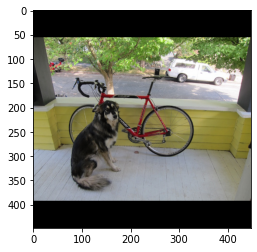

In [54]:
model.eval()
img = cv2.imread('sample_dog.jpg')
inp_dim = 448
w, h = img.shape[1], img.shape[0]
if h > w:
  h_new = inp_dim
  w_new = int(w * inp_dim/h)
  img = cv2.resize(img, (w_new, h_new))
  img = cv2.copyMakeBorder(img, 0,0,(448 - w_new)//2, (448 - w_new)//2, cv2.BORDER_CONSTANT, (128,128,128))
else:
  w_new = inp_dim
  h_new = int(h * inp_dim/w)
  img = cv2.resize(img, (w_new, h_new))
  img = cv2.copyMakeBorder(img, (448 - h_new)//2, (448 - h_new)//2, 0, 0, cv2.BORDER_CONSTANT, (128,128,128))
img =  img[:,:,::-1].transpose((2,0,1)) 
img = img[np.newaxis,:,:,:]/255.0       
img = torch.from_numpy(img).float()     
pre = model(img, 'cpu')
img_attri = write_result(pre)
print(img_attri)
img = img.squeeze(0)
img = img.numpy()
img = np.ascontiguousarray(np.transpose(img, (1,2,0))) 
# for i in range(img_attri.size(0)):
#   attri = img_attri[i]
#   label = "{0}".format(attri[0])
#   box = attri[1:]
#   box *= 448
#   box = torchvision.ops.box_convert(box, 'cxcywh', 'xyxy')
#   box = box.numpy()
#   xmin ,ymin, xmax, ymax = box
#   #bug issues: rectangle return Umat type if np.array is not contiguous 
#   img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255,0,255), 3)
#   t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
#   img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmin)+ t_size[0] + 3, int(ymin) +t_size[1] + 4)
#                                 ,(255,0,0), 1)
#   img = cv2.putText(img, label, (int(xmin), int(ymin) + t_size[1] + 4), 
#                               cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 2)
plt.imshow(img)

In [ ]:
# def building_models_yolo_tiny(blocks):
#     # building model from block 
#     # parameters = blocks 
    
#     #model info
#     net_info = blocks[0]
#     list_module = nn.ModuleList()
#     input_size = 3
#     output_filters = []
#     is_first_connected_layer = True
#     for i, block in enumerate(blocks[2:]):
#         module = nn.Sequential() #convol module can have a lot of layer
#         #convolutional layer
#         if block['type'] == 'convolutional':
#             # arguments for conv2d
#             output_size = int(block['filters'])
#             kernel_size = int(block['size'])
#             stride = int(block['stride'])
#             pad = int(block['pad'])
#             if pad:
#                 padding = (kernel_size - 1) // 2
#             else:
#                 padding = 0
#             conv = nn.Conv2d(input_size, output_size, kernel_size = kernel_size, stride = stride, padding = padding,
#                             bias = True)
#             module.add_module('conv_{}'.format(i), conv)
                      
#             #perform activation function
#             activation_func = block['activation']
#             if activation_func == 'leaky':
#                 leaky = nn.LeakyReLU(0.1, inplace = True)
#                 module.add_module('leaky_{}'.format(i), leaky)
        
#         #maxpool
#         elif block['type'] == 'maxpool':
#             stride = int(block['stride'])
#             size = int(block['size'])
#             maxpool = nn.MaxPool2d(size, stride=stride)
#             module.add_module('maxpool_{}'.format(i), maxpool)
        
        
#         #dropout
#         elif block['type'] == 'dropout':
#             prob = float(block['probability'])
#             dropout = nn.Dropout2d(prob)
#             module.add_module('dropout_{}'.format(i), dropout)
        
#         #connected
#         elif block['type'] == 'connected':
#           output_size = int(block['output'])
#           if is_first_connected_layer:
#             flatten = nn.Flatten()
#             module.add_module('flatten_{}'.format(i), flatten)
#             input_size *= 49
#             is_first_connected_layer = False
          
#           activation_func = block['activation']
#           fc = nn.Linear(input_size, output_size)
#           module.add_module('fc_{}'.format(i), fc)
#           if activation_func == 'leaky':
#                 leaky = nn.LeakyReLU(0.1, inplace = True)
#                 module.add_module('leaky_{}'.format(i), leaky)
          

#         # elif block['type'] == 'local':
#         #   output_size = int(block['filters'])
#         #   local_convolutional = EmptyLayer()
#         #   module.add_module('local_{}'.format(i), local_convolutional)
        
#         elif block['type'] == 'detection':
#             detection =  EmptyLayer()
#             module.add_module("Detection_{}".format(i), detection)
        
#         elif block['type'] == 'crop':
#           continue
        
#         output_filters.append(output_size)
#         list_module.append(module)
#         input_size = output_size
#     return (net_info, list_module)


# class EmptyLayer(nn.Module):
#     def __init__(self):
#         super(EmptyLayer, self).__init__()

In [ ]:
# class YOLOV1tiny(nn.Module):
#   def __init__(self, file):
#       super(YOLOV1tiny, self).__init__()
#       self.blocks = parsefile(file)
#       self.net_info, self.module_list = building_models(self.blocks)
      
#       self.inp_dims = int(self.net_info['height'])
#       detection_layer = self.blocks[-1]
#       self.grid_size = int(detection_layer['side'])
#       self.num_classes = int(detection_layer['classes'])
#       self.num_box = int(detection_layer['num'])
      
#       self.float()
  
#   def forward(self, x, CUDA):
    
#     # the first one is net and second one is crop
#     for i, module in enumerate(self.blocks[2:]):
#       module_type = module['type']
#       if module_type == 'detection':
#         batch_size = x.size(0)
#         detection = x.view(batch_size, self.num_box * 5 + self.num_classes, self.grid_size, self.grid_size)
#       else:
#          x = self.module_list[i](x)
#     return detection
  

#   def load_weight(self, weightfile):
#         with open (weightfile, 'rb') as file:
#             #read the head first which include 5 32-int values
#             # information about the head file @@
#             header = np.fromfile(file, dtype = np.float32, count = 4)

            
#             #the rest is the weight of the model
#             weights = np.fromfile(file, dtype = np.float32)
#             is_first_connected_layer = True
            
#             modules = self.blocks[2:]
#             pr = 0
#             for i,module in enumerate(modules):
#                 module_type = module['type']
#                 if module_type == 'convolutional':
#                     model = self.module_list[i]
                    
#                     conv_layer = model[0]
                    
#                     #load the bias for conv
#                     layer_size = conv_layer.bias.numel()
#                     bias = torch.from_numpy(weights[pr:pr + layer_size]).view_as(conv_layer.bias)
#                     conv_layer.bias.data.copy_(bias)
#                     pr += layer_size
                    
#                     # load weight file for conv
#                     num_weight = conv_layer.weight.numel()
#                     weight = torch.from_numpy(weights[pr:pr + num_weight]).view_as(conv_layer.weight)
#                     conv_layer.weight.data.copy_(weight)
#                     pr += num_weight
                
#                 elif module_type == 'connected':
#                   model = self.module_list[i]
#                   if is_first_connected_layer:
#                     fc_layer = model[1]
#                     is_first_connected_layer = False
#                   else:
#                     fc_layer = model[0]
                  
#                   num_bias = fc_layer.bias.numel()
#                   bias = torch.from_numpy(weights[pr:pr + num_bias]).view_as(fc_layer.bias)
#                   fc_layer.bias.data.copy_(bias)
#                   pr += num_bias

#                   num_weight = fc_layer.weight.numel()
#                   weight = torch.from_numpy(weights[pr:pr + num_weight]).view_as(fc_layer.weight)
#                   pr += num_weight
#             print(weights[pr:])


#   # def load_pretrain_weight(self, weightfile):
#   #   with open (weightfile, 'rb') as file:
#   #           #read the head first which include 5 32-int values
#   #           # information about the head file @@
#   #           header = np.fromfile(file, dtype = np.int32, count = 4)
#   #           self.header = torch.from_numpy(header)
#   #           self.seen = self.header[2] #number of images seen by the network during training
            
#   #           #the rest is the weight of the model
#   #           weights = np.fromfile(file, dtype = np.float32)
            
#   #           modules = self.blocks[2:]
#   #           pr = 0
#   #           for i,module in enumerate(modules):
#   #               module_type = module['type']
#   #               if module_type == 'convolutional':
#   #                   model = self.module_list[i]

#   #                   #check if there is a batchnorm
#   #                   try:
#   #                       batch_norm = int(module['batch_normalize'])
#   #                   except:
#   #                       batch_norm = 0
                    
#   #                   conv_layer = model[0]
#   #                   # weight for batch_normalisation include : bias, weight, running means and running vals
#   #                   if batch_norm:
#   #                       batch_layer = model[1]
#   #                       layer_size = batch_layer.bias.numel()
                        
#   #                       #bias 
#   #                       bias = torch.from_numpy(weights[pr:pr + layer_size]).view_as(batch_layer.bias)
#   #                       batch_layer.bias.data.copy_(bias)
#   #                       pr += layer_size
                        
#   #                       #weight
#   #                       weight = torch.from_numpy(weights[pr:pr + layer_size]).view_as(batch_layer.weight)
#   #                       batch_layer.weight.data.copy_(weight)
#   #                       pr += layer_size
                        
#   #                       #running_mean
#   #                       mean = torch.from_numpy(weights[pr:pr + layer_size]).view_as(batch_layer.running_mean)
#   #                       batch_layer.running_mean.copy_(mean)
#   #                       pr += layer_size
                        
#   #                       #running_val
#   #                       var = torch.from_numpy(weights[pr:pr + layer_size]).view_as(batch_layer.running_var)
#   #                       batch_layer.running_var.data.copy_(var)
#   #                       pr += layer_size
#   #                   else:
#   #                       #load the bias for conv
#   #                       layer_size = conv_layer.bias.numel()
#   #                       bias = torch.from_numpy(weights[pr:pr + layer_size]).view_as(conv_layer.bias)
#   #                       conv_layer.bias.data.copy_(bias)
#   #                       pr += layer_size
                    
#   #                   # load weight file for conv
#   #                   num_weight = conv_layer.weight.numel()
#   #                   weight = torch.from_numpy(weights[pr:pr + num_weight]).view_as(conv_layer.weight)
#   #                   conv_layer.weight.data.copy_(weight)
#   #                   pr += num_weight
#   #               elif module_type == 'connected':
#   #                 #initialize the weight for the connected layer
#   #                 model = self.module_list[i]
#   #                 fc_layer = model[1]
                  
#   #                 num_bias = fc_layer.bias.numel()
#   #                 bias = torch.rand((fc_layer.bias.size()), requires_grad=True)
#   #                 fc_layer.bias.data.copy_(bias)

#   #                 num_weight = fc_layer.weight.numel()
#   #                 weight = torch.rand((fc_layer.weight.size()), requires_grad=True)